In [30]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, classification_report



       business_id                                      business_name  \
4            97722                                 THE CHURRO FACTORY   
12           95023                                            Sakesan   
15           94977                      94977 Portables 2 Carvery/BBQ   
23           96578                                 GOOOD FORTUNE LLC.   
33           94928                                   Purple Kow, KAMS   
...            ...                                                ...   
53926        98072                           SASA JAPANESE RESTAURANT   
53940        99252  CALIFORNIA PACIFIC MEDICAL CENTER-VAN NESS CAMPUS   
53944        95366                                     Casa Lucas MKT   
53959       100215                            CHICKEN N WAFFLES PLACE   
53969        95021                                         Wing Wings   

       business_city business_state    inspection_id         inspection_date  \
4      San Francisco             CA   97722

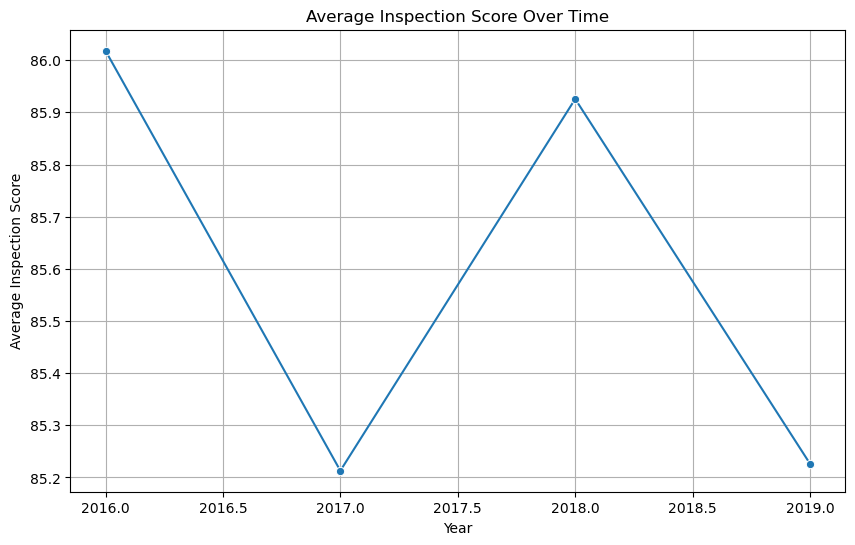

In [33]:
# Load the dataset
file_path = 'data.csv'
restaurant_data = pd.read_csv(file_path)

# Drop unnecessary columns
columns_to_drop = [
    'business_longitude','business_latitude','business_postal_code','business_address','business_phone_number', 'business_location', 'Neighborhoods',
    'SF Find Neighborhoods', 'Current Police Districts', 
    'Current Supervisor Districts', 'Analysis Neighborhoods'
]
restaurant_data = restaurant_data.drop(columns=columns_to_drop)

# Drop rows with missing values
restaurant_data = restaurant_data.dropna()
print(restaurant_data)
# Encode categorical variables
for col in ['inspection_type', 'business_city', 'business_state']:
    le = LabelEncoder()
    restaurant_data[col] = le.fit_transform(restaurant_data[col].astype(str))

# Convert inspection_date to datetime and extract features
restaurant_data['inspection_date'] = pd.to_datetime(restaurant_data['inspection_date'], errors='coerce')
restaurant_data['inspection_year'] = restaurant_data['inspection_date'].dt.year
restaurant_data['inspection_month'] = restaurant_data['inspection_date'].dt.month
restaurant_data['inspection_day'] = restaurant_data['inspection_date'].dt.day

# Trend of average inspection scores over time
yearly_scores = restaurant_data.groupby('inspection_year')['inspection_score'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_scores, x='inspection_year', y='inspection_score', marker='o')
plt.title('Average Inspection Score Over Time')
plt.xlabel('Year')
plt.ylabel('Average Inspection Score')
plt.grid(True)
plt.show()

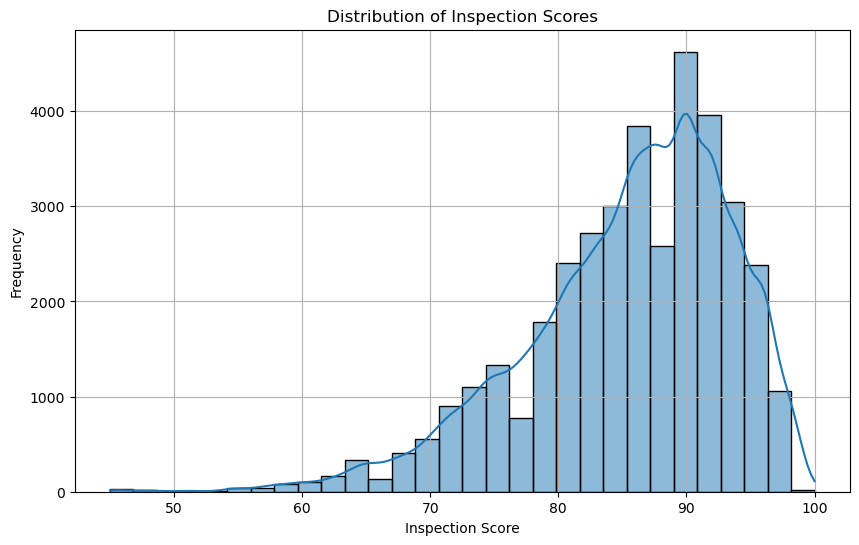

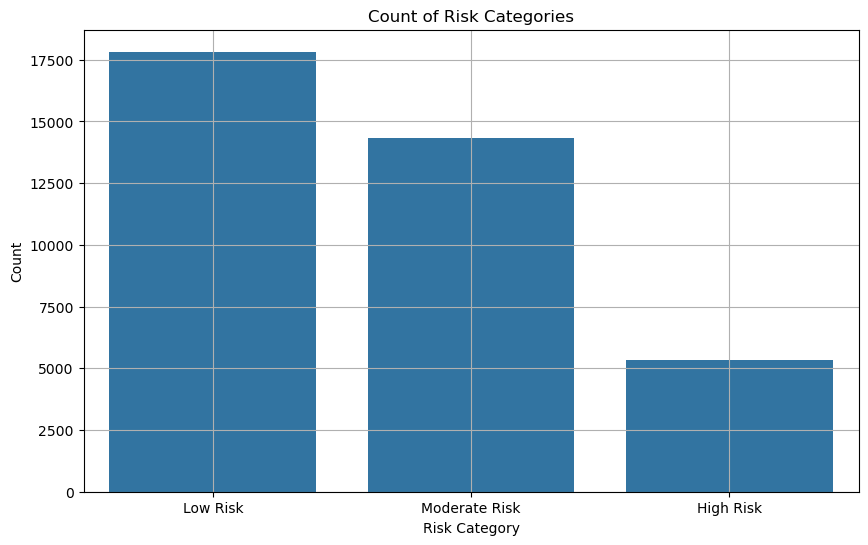

In [34]:
# Visualize the distribution of inspection scores
plt.figure(figsize=(10, 6))
sns.histplot(restaurant_data['inspection_score'], bins=30, kde=True)
plt.title('Distribution of Inspection Scores')
plt.xlabel('Inspection Score')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Visualize the count of risk categories
plt.figure(figsize=(10, 6))
sns.countplot(data=restaurant_data, x='risk_category', order=restaurant_data['risk_category'].value_counts().index)
plt.title('Count of Risk Categories')
plt.xlabel('Risk Category')
plt.ylabel('Count')
plt.grid()
plt.show()



In [35]:
# Prepare data for Inspection Score Prediction
score_data = restaurant_data.dropna(subset=['inspection_score'])
features_score = score_data.drop(columns=['inspection_score', 'inspection_date', 'risk_category', 'violation_id', 'violation_description', 'business_name', 'business_id'])
features_score = pd.get_dummies(features_score)

# Split data for score prediction
X_train_score, X_test_score, y_train_score, y_test_score = train_test_split(
    features_score, score_data['inspection_score'], test_size=0.9, random_state=42
)
X_test_score = X_test_score.reindex(columns=X_train_score.columns, fill_value=0)

# Train and evaluate Inspection Score Prediction model
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train_score, y_train_score)
y_pred_score = regressor.predict(X_test_score)

print("Inspection Score Prediction - MAE:", mean_absolute_error(y_test_score, y_pred_score))
print("Inspection Score Prediction - RMSE:", np.sqrt(mean_squared_error(y_test_score, y_pred_score)))

# Prepare data for Violation Risk Classification
risk_data = restaurant_data.dropna(subset=['risk_category'])
features_risk = risk_data.drop(columns=['risk_category', 'inspection_date', 'inspection_score', 'violation_id', 'violation_description', 'business_name', 'business_id'])
features_risk = pd.get_dummies(features_risk)

# Split data for risk classification
X_train_risk, X_test_risk, y_train_risk, y_test_risk = train_test_split(
    features_risk, risk_data['risk_category'], test_size=0.9, random_state=42
)
X_test_risk = X_test_risk.reindex(columns=X_train_risk.columns, fill_value=0)



Inspection Score Prediction - MAE: 5.147222370488984
Inspection Score Prediction - RMSE: 7.165153284308752


In [36]:
# Train and evaluate Violation Risk Classification model
classifier_risk = RandomForestClassifier(random_state=42)
classifier_risk.fit(X_train_risk, y_train_risk)
y_pred_risk = classifier_risk.predict(X_test_risk)

print("Violation Risk Classification - Accuracy:", accuracy_score(y_test_risk, y_pred_risk))
print("Violation Risk Classification - Report:\n", classification_report(y_test_risk, y_pred_risk))

# Prepare data for Good Quality Prediction Next Year
GOOD_QUALITY_THRESHOLD = 90
restaurant_data['is_good_quality'] = np.where(restaurant_data['inspection_score'] >= GOOD_QUALITY_THRESHOLD, 1, 0)

# Sort values and group by 'business_id' to create 'good_quality_next_year' column
restaurant_data['good_quality_next_year'] = restaurant_data.sort_values(by=['business_id', 'inspection_date']) \
    .groupby('business_id')['is_good_quality'].shift(-1)  # Removed the extra space here

# Drop rows with NaN in 'good_quality_next_year'
restaurant_data = restaurant_data.dropna(subset=['good_quality_next_year'])

features_quality_prediction = restaurant_data.drop(columns=[
    'inspection_score', 'inspection_date', 'is_good_quality', 'violation_id', 
    'violation_description', 'good_quality_next_year', 'business_name', 'business_id'
])
features_quality_prediction = pd.get_dummies(features_quality_prediction)
target_quality_prediction = restaurant_data['good_quality_next_year']

# Split data for good quality prediction
X_train_quality, X_test_quality, y_train_quality, y_test_quality = train_test_split(
    features_quality_prediction, target_quality_prediction, test_size=0.9, random_state=42
)

# Train and evaluate Good Quality Prediction model
classifier_quality = RandomForestClassifier(random_state=42)
classifier_quality.fit(X_train_quality, y_train_quality)
y_pred_quality = classifier_quality.predict(X_test_quality)

print("Good Quality Prediction - Accuracy:", accuracy_score(y_test_quality, y_pred_quality))



Violation Risk Classification - Accuracy: 0.45167986240844527
Violation Risk Classification - Report:
                precision    recall  f1-score   support

    High Risk       0.16      0.04      0.06      4830
     Low Risk       0.48      0.84      0.61     16053
Moderate Risk       0.37      0.12      0.18     12840

     accuracy                           0.45     33723
    macro avg       0.33      0.33      0.28     33723
 weighted avg       0.39      0.45      0.37     33723

Good Quality Prediction - Accuracy: 0.6725890079502247


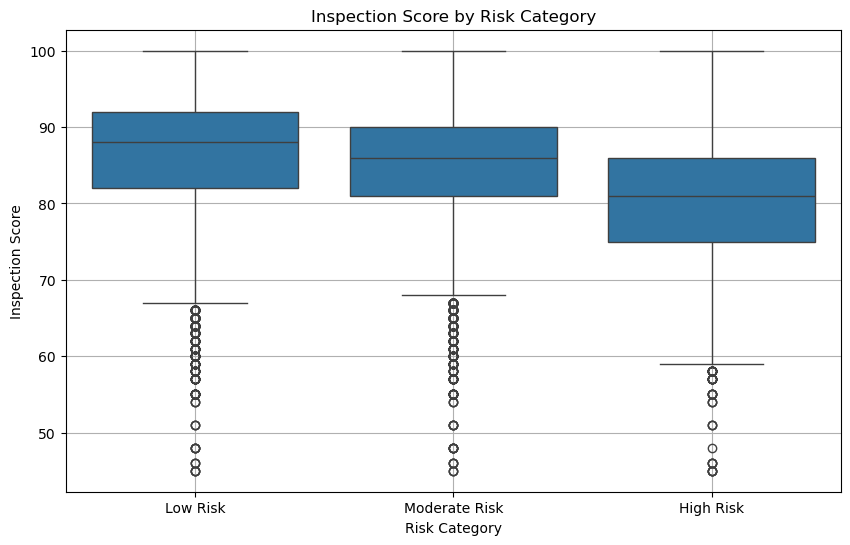

### Summary of Findings ###
1. The distribution of inspection scores shows a tendency towards higher scores.
2. The count of risk categories indicates the prevalence of certain risks.
3. The models developed for predicting inspection scores and risk categories show promising results.
4. The analysis of good quality predictions suggests a significant correlation with past inspection scores.


In [37]:
# Visualize the relationship between inspection score and risk category
plt.figure(figsize=(10, 6))
sns.boxplot(data=restaurant_data, x='risk_category', y='inspection_score')
plt.title('Inspection Score by Risk Category')
plt.xlabel('Risk Category')
plt.ylabel('Inspection Score')
plt.grid()
plt.show()

# Summary of findings
print("### Summary of Findings ###")
print("1. The distribution of inspection scores shows a tendency towards higher scores.")
print("2. The count of risk categories indicates the prevalence of certain risks.")
print("3. The models developed for predicting inspection scores and risk categories show promising results.")
print("4. The analysis of good quality predictions suggests a significant correlation with past inspection scores.")